In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch_geometric.nn as gnn
from torch.utils.data import Dataset,DataLoader
import torch_geometric
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,roc_curve
import torchvision
import particle
import math
from tqdm.notebook import tqdm

# Task 1

Part 1

In [2]:
# dev = qml.device('default.qubit', wires=5, shots=1000)
# @qml.qnode(dev)
def Operator_t1_p1():
    li = []
    for i in range(5):li.append(qml.Hadamard(i))
    for i in range(0,4):li.append(qml.CNOT(wires=[i,i+1]))
    li.append(qml.SWAP([0,4]))
    for i in range(5): li.append(qml.RX(np.pi/2,wires=i)) # any sounded ambigous so I added to all
    return li

(<Figure size 1000x600 with 1 Axes>, <Axes:>)


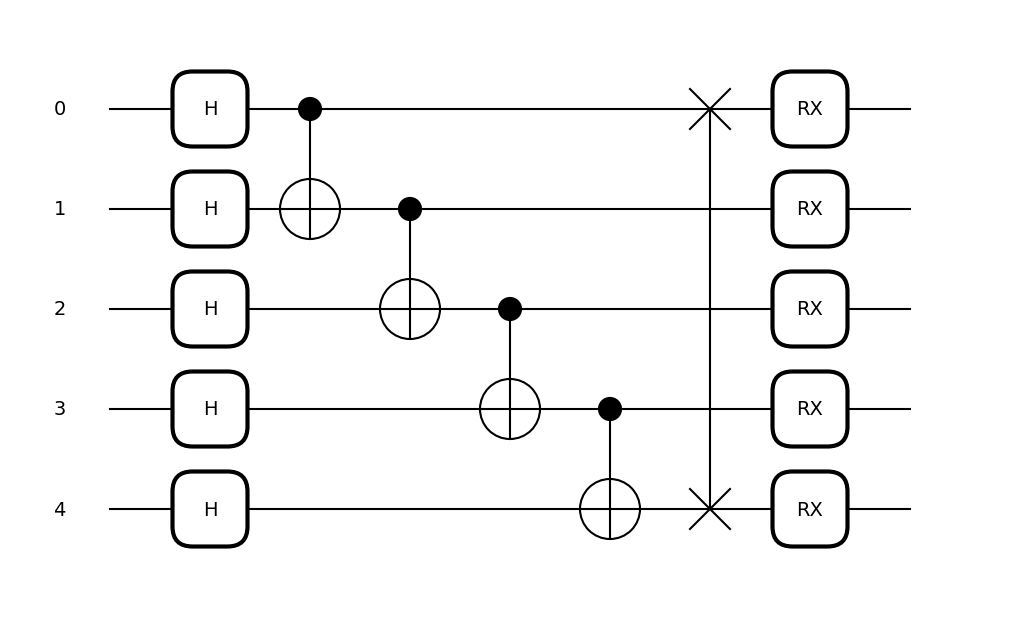

In [3]:
operator = qml.prod(*Operator_t1_p1())
print(qml.draw_mpl(Operator_t1_p1)())

In [4]:
# dev = qml.device('default.qubit', wires=5, shots=1000)
# @qml.qnode(dev)
def Operator_t1_p1():
    li = []
    for i in range(5):li.append(qml.Hadamard(i))
    for i in range(0,4):li.append(qml.CNOT(wires=[i,i+1]))
    li.append(qml.SWAP([0,4]))
    for i in range(5): li.append(qml.RX(np.pi/2,wires=i)) # any sounded ambigous so I added to all
    return li

Part 2

In [5]:
dev = qml.device('default.qubit', wires=[*[i for i in range(4)],'ancilla'], shots=1000)
@qml.qnode(dev)
def Circuit_t1_p2():
    qml.Hadamard(0)
    qml.RX(np.pi/3,wires=1)
    for i in [2,3,'ancilla']:qml.Hadamard(wires=i)
    qml.CSWAP(wires=['ancilla',0,2])
    qml.CSWAP(wires=['ancilla',1,3])
    qml.Hadamard(wires='ancilla')
    return qml.expval(qml.PauliZ(['ancilla']))


(<Figure size 700x600 with 1 Axes>, <Axes:>)


Text(0.5, 1.0, '<Ancilla>=0.522')

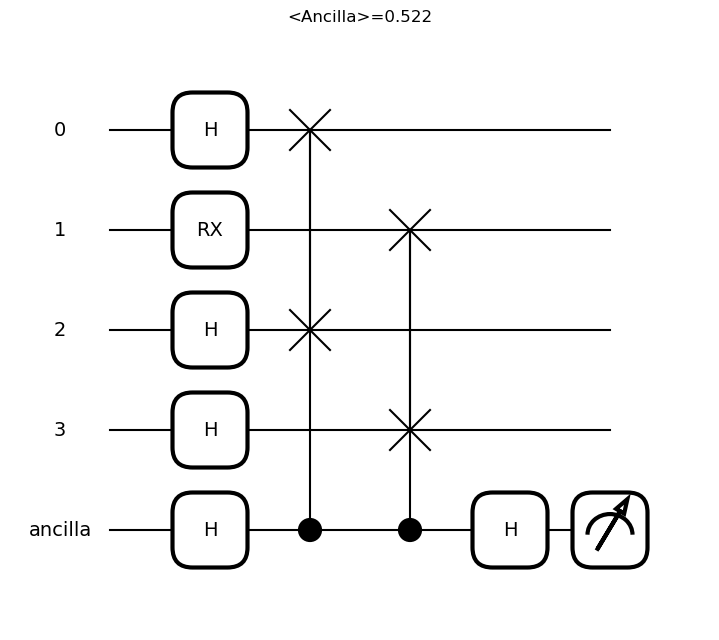

In [6]:
print(qml.draw_mpl(Circuit_t1_p2)())
plt.title('<Ancilla>={:.3f}'.format(Circuit_t1_p2()))

# Task 2

I used "Cambridge-Aachen algorithm" distance in order to find three nearest neighbors of each particle and put edges between them. Edge weight was set as 
.8-"Cambridge-Aachen algorithm" distance.

Our task is type of graph classification. Since we are looking for a global feature, I have decided to use variants of graph convolutional networks. In order to perform the classification, I took the global max/mean of the output then concatanated it with some calculated global properties and fed it to a fully connected network. I picked AttentiveFP model from "Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism" and GFN from "Are Powerful Graph Neural Nets Necessary? A Dissection on Graph Classification" as their prowess in graph classification was shown on these papers. I wasn't able to finetune models in a short time given that dataset is so large.

Results show that their performance is similar. This was also the case with other architectures I have tried. I suspect some of the data (20%) is really hard to predict compared to the rest of it (80%). It is also possible models are undertrained and further training is needed.

In [65]:
def train(model, loss_fn, train_dl, val_dl, optimizer, epochs):
    try: 
        history = {} 

        history['tr_loss'] = np.ones(epochs)*1e15
        history['val_loss'] = np.ones(epochs)*1e15
        bar_epoch = tqdm(range(epochs))
        state = model.state_dict().copy()
        for epoch in bar_epoch:

            train_loss         = 0.0
            val_loss       = 0.0

            model.train()
            bar_batch = tqdm(train_dl,leave=False)
            for batch in bar_batch:

                optimizer.zero_grad()
                loss = loss_fn(model,batch)

                loss.mean().backward()

                optimizer.step()

                train_loss         += loss.sum().item()
                bar_batch.set_postfix_str('{:.3e}'.format(loss.mean().item()))
            train_loss  = train_loss / len(train_dl.dataset)

            model.eval()

            for batch in val_dl:

                with torch.no_grad():loss = loss_fn(model,batch).detach()
                val_loss         += loss.sum().item()

            val_loss = val_loss / len(val_dl.dataset)

            history['tr_loss'][epoch]=(train_loss)
            history['val_loss'][epoch]=(val_loss)

            if np.min(history['val_loss'])== history['val_loss'][epoch]:
                state = model.state_dict().copy()

            bar_epoch.set_postfix_str('Tr: %.3e, Val: %.3e, Min loss: %.3e at %.d'%(train_loss,val_loss,np.min(history['val_loss']),np.argmin(history['val_loss'])),refresh=True)


        return {'state':state,'history':history}
    except KeyboardInterrupt:
        return {'state':state,'history':history}

In [8]:
from functools import partial

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import GCNConv

### Taken from https://github.com/chentingpc/gfn #######
class GFN(torch.nn.Module):
    """GCN with BN and residual connection."""
    def __init__(self, hidden, hidden_in,num_feat_layers=2, num_conv_layers=3,
                 num_fc_layers=1, gfn=True, collapse=False, residual=False,
                 res_branch="BNConvReLU", global_pool="sum", dropout=0,
                 edge_norm=True):
        super(GFN, self).__init__()
        assert num_feat_layers == 1, "more feat layers are not now supported"
        self.conv_residual = residual
        self.fc_residual = False  # no skip-connections for fc layers.
        self.res_branch = res_branch
        self.collapse = collapse
        
        assert "sum" in global_pool or "mean" in global_pool, global_pool
        if "sum" in global_pool:
            self.global_pool = global_add_pool
        else:
            self.global_pool = global_mean_pool
        self.dropout = dropout
        GConv = partial(GCNConv, edge_norm=edge_norm, gfn=gfn)


        self.use_xg = False

        self.bn_feat = BatchNorm1d(hidden_in)
        feat_gfn = True  # set true so GCNConv is feat transform
        self.conv_feat = GCNConv(hidden_in, hidden, gfn=feat_gfn)
        if "gating" in global_pool:
            self.gating = torch.nn.Sequential(
                Linear(hidden, hidden),
                torch.nn.ReLU(),
                Linear(hidden, 1),
                torch.nn.Sigmoid())
        else:
            self.gating = None
        self.bns_conv = torch.nn.ModuleList()
        self.convs = torch.nn.ModuleList()
        if self.res_branch == "resnet":
            for i in range(num_conv_layers):
                self.bns_conv.append(BatchNorm1d(hidden))
                self.convs.append(GCNConv(hidden, hidden, gfn=feat_gfn))
                self.bns_conv.append(BatchNorm1d(hidden))
                self.convs.append(GConv(hidden, hidden))
                self.bns_conv.append(BatchNorm1d(hidden))
                self.convs.append(GCNConv(hidden, hidden, gfn=feat_gfn))
        else:
            for i in range(num_conv_layers):
                self.bns_conv.append(BatchNorm1d(hidden))
                self.convs.append(GConv(hidden, hidden))
        self.bn_hidden = BatchNorm1d(hidden)
        self.bns_fc = torch.nn.ModuleList()
        self.lins = torch.nn.ModuleList()
        for i in range(num_fc_layers - 1):
            self.bns_fc.append(BatchNorm1d(hidden))
            self.lins.append(Linear(hidden, hidden))
        self.lin_class = Linear(hidden, 1)

        # BN initialization.
        for m in self.modules():
            if isinstance(m, (torch.nn.BatchNorm1d)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0.0001)

    def reset_parameters(self):
        raise NotImplemented(
            "This is prune to bugs (e.g. lead to training on test set in "
            "cross validation setting). Create a new model instance instead.")

    def forward_collapse(self, x, edge_index, batch, xg=None):
        x = self.bn_feat(x)
        gate = 1 if self.gating is None else self.gating(x)
        x = self.global_pool(x * gate, batch)
        x = x if xg is None else x + xg
        for i, lin in enumerate(self.lins):
            x_ = self.bns_fc[i](x)
            x_ = F.relu(lin(x_))
            x = x + x_ if self.fc_residual else x_
        x = self.lin_class(x)
        return F.log_softmax(x, dim=-1)

    def forward(self, x, edge_index, batch, edge_attr,xg=None):
        x = self.bn_feat(x)
        x = F.relu(self.conv_feat(x, edge_index))
        for i, conv in enumerate(self.convs):
            x_ = self.bns_conv[i](x)
            x_ = F.relu(conv(x_, edge_index))
            x = x + x_ if self.conv_residual else x_
        gate = 1 if self.gating is None else self.gating(x)
        x = self.global_pool(x * gate, batch)
        return x

    def forward_BNReLUConv(self, x, edge_index, batch, xg=None):
        x = self.bn_feat(x)
        x = self.conv_feat(x, edge_index)
        for i, conv in enumerate(self.convs):
            x_ = F.relu(self.bns_conv[i](x))
            x_ = conv(x_, edge_index)
            x = x + x_ if self.conv_residual else x_
        x = self.global_pool(x, batch)
        x = x if xg is None else x + xg
        for i, lin in enumerate(self.lins):
            x_ = F.relu(self.bns_fc[i](x))
            x_ = lin(x_)
            x = x + x_ if self.fc_residual else x_
        x = F.relu(self.bn_hidden(x))
        if self.dropout > 0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin_class(x)
        return F.log_softmax(x, dim=-1)

    def forward_ConvReLUBN(self, x, edge_index, batch, xg=None):
        x = self.bn_feat(x)
        x = F.relu(self.conv_feat(x, edge_index))
        x = self.bn_hidden(x)
        for i, conv in enumerate(self.convs):
            x_ = F.relu(conv(x, edge_index))
            x_ = self.bns_conv[i](x_)
            x = x + x_ if self.conv_residual else x_
        x = self.global_pool(x, batch)
        x = x if xg is None else x + xg
        for i, lin in enumerate(self.lins):
            x_ = F.relu(lin(x))
            x_ = self.bns_fc[i](x_)
            x = x + x_ if self.fc_residual else x_
        if self.dropout > 0:
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin_class(x)
        return F.log_softmax(x, dim=-1)

    def forward_resnet(self, x, edge_index, batch, xg=None):
        # this mimics resnet architecture in cv.
        x = self.bn_feat(x)
        x = self.conv_feat(x, edge_index)
        for i in range(len(self.convs) // 3):
            x_ = x
            x_ = F.relu(self.bns_conv[i*3+0](x_))
            x_ = self.convs[i*3+0](x_, edge_index)
            x_ = F.relu(self.bns_conv[i*3+1](x_))
            x_ = self.convs[i*3+1](x_, edge_index)
            x_ = F.relu(self.bns_conv[i*3+2](x_))
            x_ = self.convs[i*3+2](x_, edge_index)
            x = x + x_
        x = self.global_pool(x, batch)
        return x

    def __repr__(self):
        return self.__class__.__name__

In [9]:
def load_files(f_list):
    X_load=[]
    y_load=[]
    
    for f_ in f_list:
        f_name = os.path.join(jet_path,f_)
        with np.load(f_name) as temp_file:
            X_load.append(torch.from_numpy(temp_file['X']))
            y_load.append(torch.from_numpy(temp_file['y']))
    
    M_max = max([_.shape[1] for _ in X_load])

    length = np.cumsum([_.shape[0] for _ in X_load])
    X = torch.zeros(length[-1],M_max,4)
    for i in range(len((X_load))):
        X[(100000*(i)):(100000*(i+1)),:X_load[i].shape[1]] = X_load[i]

    y = torch.hstack(y_load)

    y=y[(X!=0).sum(axis=(1,2))>8]
    X=X[(X!=0).sum(axis=(1,2))>8]
    add = torch.zeros(*X.shape[:2],8)
    for i,n in enumerate( [11.,   13.,   22.,  130.,  211.,  321., 2112., 2212]):
        add[...,i][X[:,:,-1]==n]=1
        add[...,i][X[:,:,-1]==-n]=-1

    X = torch.cat((X[:,:,:-1],add),dim=-1)
    return X,y

In [10]:
def preprocess(X):
    mass_particles = []
    for i,n in enumerate( [11.,   13.,   22.,  130.,  211.,  321., 2112., 2212]): mass_particles.append(particle.Particle.from_pdgid(n).mass/1000)
    mass_particles = torch.tensor(mass_particles)
    mass = X[:,:,3:].abs() @ mass_particles[:]

    theta = torch.arctan(torch.exp(-X[:,:,1]))*2
    phi = X[:,:,2]
    pt = X[:,:,0]
    mt= (pt**2+mass).sqrt()
    E = mt*torch.cosh(X[...,1])
    E_jet =E.sum(axis=1)

    Px = pt*torch.cos(phi)
    Py = pt*torch.sin(phi)
    Pz = mt*torch.sinh(X[...,1])

    P = torch.cat((Px[...,None],Py[...,None],Pz[...,None]),2 )

    P_jet = (P).sum(axis=1)
    Pt_jet = (P_jet[...,:2]**2).sum(axis=-1).sqrt()
    M_jet = (E_jet**2-(P_jet**2).sum(axis=-1)).sqrt()
    Y_jet =torch.log( (E_jet+P_jet[:,-1])/(E_jet-P_jet[:,-1]))/2

    G_features = torch.stack((E.max(axis=1).values/E_jet,M_jet,(X[:,:,0]!=0).sum(axis=1)),-1)
    return G_features

In [11]:
def get_edges(graph):
    edges=[]
    tot_nodes = (graph[:,1]!=0).sum()
    if tot_nodes>0:
        for i in range(tot_nodes):
            list_edges=((graph[:,[1,2]]-graph[i,[1,2]])**2).sum(axis=1).argsort()[1:4]
            # if list_edges.shape[0]<3: print(graph)
            edges.append( torch.vstack((torch.ones(1,min([3,list_edges.shape[0]]))*i,list_edges )))
        edges = torch.hstack(edges)
        # return torch.sort(edges,axis=1)
        edges = torch.unique(torch.sort(edges,axis=0).values,dim=1)
    
    return edges
    

In [12]:
class Dataset_Basic(Dataset):
    def __init__(self,inputs,g_features, output):
        self.inputs = inputs
        self.output = output
        self.g_features = g_features
            
        
    def __len__(self):

        return self.inputs.shape[0]
    def __getitem__(self, idx):

        max_length = (self.inputs[idx,:,1]!=0).sum()
        edges=get_edges(self.inputs[idx,:max_length]).T.long()
        try:
            edge_weights = ((self.inputs[idx,edges[:,0]][:,[1,2]]-self.inputs[idx,edges[:,1]][:,[1,2]])**2).sum(axis=1).sqrt()
        except: print(edges.shape)
        # edge_weights = (1/edge_weights).sum()*1/edge_weights
        edge_weights = .8 - edge_weights

        sample={'edges':edges,'labels':self.output[[idx]],'edge_weights':edge_weights,'features':self.inputs[idx,:max_length,:],\
               'graph_features':self.g_features[[idx]]}
        
        return sample

def collate_fn(data):

    l = len(data)
    csm = torch.from_numpy(np.cumsum([0]+[ i['features'].shape[0] for i in data]))
    
    dim= len(data[0].keys())-1
    Data = {j:[] for j in data[0].keys() }

    for i in range(l):
        
        Data['edges'].append(data[i]['edges']+csm[i])
        for j in data[0].keys(): 
            if j != 'edges': 

                Data[j].append(data[i][j].reshape(data[i][j].shape[0],-1)) 
    sample={j:torch.cat(Data[j],0) for j in Data.keys()}
    sample.update({'batch_sizes':csm})
    return sample    


class GNN_model(nn.Module):
    def __init__(self,architecture):
        super(GNN_model,self).__init__()
        if architecture =='GFN':
            self.GNN = GFN(16, num_feat_layers=1,hidden_in=11, num_conv_layers=3,
                 num_fc_layers=2, gfn=True, collapse=False, residual=False,
                 res_branch="BNConvReLU", global_pool="mean", dropout=0,
                 edge_norm=True)
        elif architecture == 'GraphSAGE':
            self.GNN = gnn.GraphSAGE(in_channels=11,out_channels=16,hidden_channels =16 ,
                          num_layers=6)
        elif architecture == 'AttentiveFP':
            self.GNN = gnn.AttentiveFP(in_channels=11,out_channels=16,hidden_channels =16 ,
                          num_layers=6,edge_dim=1,num_timesteps=1)
        self.layer = nn.Sequential(nn.Linear(19,8),nn.ReLU(),nn.Linear(8,8),nn.ReLU(),
                                  nn.Linear(8,1),nn.Sigmoid())
        self.architecture = architecture 
    def forward(self,features,edges,batch_sizes,graph_features,edge_weights):
        index_node= torch.zeros(features.shape[0]).type(torch.int64)
        for i in range(batch_sizes.shape[0]-1):
            index_node[batch_sizes[i]:batch_sizes[i+1]] = i
            
        if self.architecture in ['AttentiveFP','GFN']: 
            latent=self.GNN(x=features,edge_index=edges.T,edge_attr=edge_weights,batch=index_node)
        
        else:
            latent_node=self.GNN(x=features,edge_index=edges.T,edge_attr=edge_weights)
            latent = gnn.pool.global_max_pool(latent_node.squeeze(),index_node.type(torch.int64))

        return self.layer(torch.cat((latent,graph_features),1))
    
    
        

In [13]:
torch.manual_seed(42)
jet_path = '/home/e_/OneDrive/SoC/Tasks/Task-2-jets/'
f_list= os.listdir(jet_path)[:2]
X,y=load_files(f_list)
G_features = preprocess(X)

In [14]:
dataset_jet=Dataset_Basic(X,G_features,y) 
tr_ds,val_ds = torch.utils.data.random_split(dataset_jet,[.9,.1])
tr_dl = DataLoader(tr_ds,batch_size=64,collate_fn=collate_fn,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=64,collate_fn=collate_fn,shuffle=True)

Graph Feature Network

In [15]:
model = GNN_model('GFN')
optim = torch.optim.Adam(model.parameters(),lr=2.5e-4)
def loss_fn(model,sample): 
    y = sample.pop('labels')
    return torch.nn.BCELoss(reduction='none')(model(**sample).float(),y.float())

train_gfn = train(model,loss_fn, tr_dl,val_dl,optim,3)
    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

In [16]:
# jet_path = '/home/e_/OneDrive/SoC/Tasks/Task-2-jets/'
jet_path = os.getcwd()+'/Task-2-jets/'
f_list= os.listdir(jet_path)[3:4]
X,y=load_files(f_list)
G_features = preprocess(X)

In [24]:
test = DataLoader(Dataset_Basic(X,G_features,y),batch_size=64,collate_fn=collate_fn)

In [25]:
# torch.save(train_gfn['state'],'GFN.pt')

In [34]:
answers = []
model.eval()
y_test=[]
with torch.no_grad():
    for i in tqdm(test):
        
        y_test.append(i.pop('labels'))
        answers.append(model(**i))
        
yhat = torch.cat(answers,0)
y_test = torch.cat(y_test,0)


  0%|          | 0/1563 [00:00<?, ?it/s]

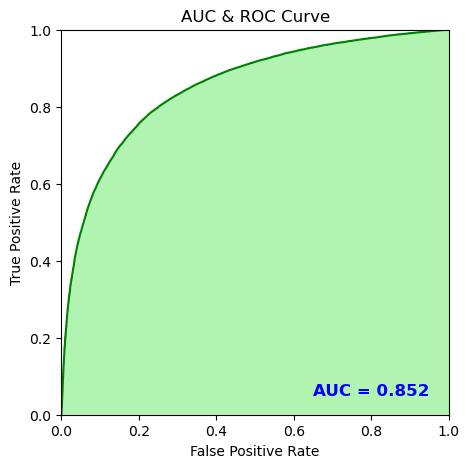

<AxesSubplot:>

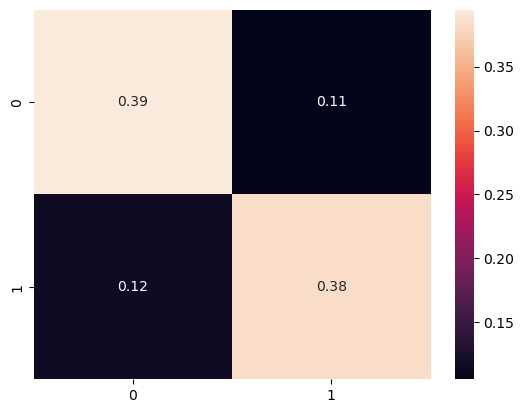

In [35]:
auc = roc_auc_score(y_test, yhat)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, yhat)

plt.figure(figsize=(5, 5))

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.3f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
plt.figure()
sns.heatmap(confusion_matrix(y_test,yhat>=.5 )/yhat.shape[0],annot=True)

In [36]:
model = GNN_model('AttentiveFP')

optim = torch.optim.Adam(model.parameters(),lr=2.5e-4)
def loss_fn(model,sample): 
    y = sample.pop('labels')
    return torch.nn.BCELoss(reduction='none')(model(**sample).float(),y.float())

train_gcn = train(model,loss_fn, tr_dl,val_dl,optim,3)
    

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

In [37]:
torch.save(model.state_dict(),'AttentiveFP')

In [39]:
answers = []
model.eval()
y_test=[]
with torch.no_grad():
    for i in tqdm(test):
        
        y_test.append(i.pop('labels'))
        answers.append(model(**i))
        
yhat = torch.cat(answers,0)
y_test = torch.cat(y_test,0)


  0%|          | 0/1563 [00:00<?, ?it/s]

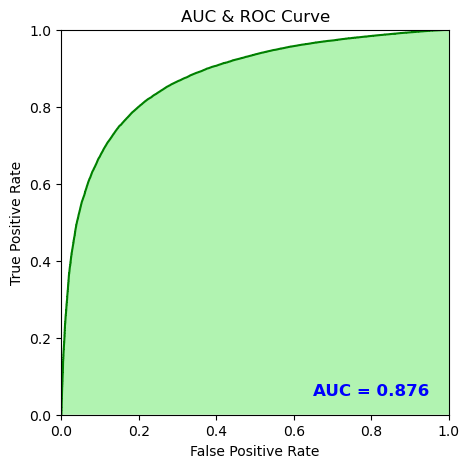

<AxesSubplot:>

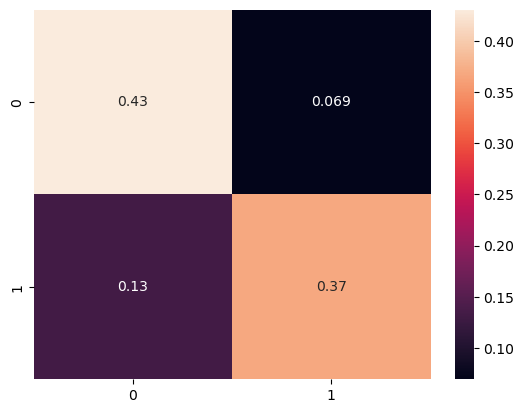

In [40]:
auc = roc_auc_score(y_test, yhat)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, yhat)

plt.figure(figsize=(5, 5))

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.3f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
plt.figure()
sns.heatmap(confusion_matrix(y_test,yhat>=.5 )/yhat.shape[0],annot=True)

# Task 3 

Adiabatic quantum computing is a not-gate based quantum computing method. Main idea is that one can find ground state of a Hamiltonian by starting in ground state of a simple hamiltonian and adiabatically changing Hamiltonian to the desired Hamiltonian. Using this method, Ising machines can find the ground states of a Ising model. This is equivalent to solving Quadratic Unconstrained Binary Optimization (QUBO) if all terms in the Hamiltonian is quadratic. This is fortunate given that solving QUBO is a NP-complete problem. Solving NP-complete problems is significant since all problems in NP can be mapped to all NP-complete problems in polynomial time. Therefore, Ising machines can be used to solve NP-problems.

One can think Ising machines are rather limited compared to the gate based quantum computing. This is understandable as only thing they can solve is
$$\min_{C}(\sum_{i<=j}^{N}A_{ij}C_iC_j)), \quad C_i\in{0,1}$$

However, there are many applications of Ising machines, including quantum machine learning. For instance in "Training a Binary Classifier with the Quantum Adiabatic Algorithm" Neven et al. shows how one can utilize Ising machines to create a binary classifier by combining bunch of weak classifiers. Let's say we want to construct strong classifier $H(x)$ from weak classifiers $h_i(x)$ in the following form

$$H(x)=\text{sign}\left(\sum_{i=1}^{N}w_ih_i(x)\right).$$

This can be achieved by finding the weights that minimizes the following expression

$$L(w)=\sum_{s=1}^S\left(\sum_{i=1}^N w_ih_i(x_s)-y_s \right)^2+ \lambda ||w||, \quad w_i\in 0,1$$

where second term applies the L1 regularization. L1 Combining those weak classifiers to obtain the optimal classifier is a combinatoric problem (assuming they can be combined in discreet values) and it will take a long time with a classic computer. However, Ising machines can solve this problem easily. There might be many interesting methods that one can use to involve Ising machines in QML like this one waiting to be discovered.



I am really not good at tensorflow so I implemented the QGAN with pytorch.

In [ ]:
# Quantum simulator
n_qubits = 11
dev = qml.device("lightning.qubit", wires=n_qubits)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_path = '/home/e_/OneDrive/SoC/Tasks/Task-6-jets/'

In [ ]:
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")

def qc_gen(noise, weights,n_qubits):
    q_depth=3
    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    # Repeated layer
    for i in range(q_depth):

        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(11)))


# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights,n_qubits,a_qubits):
    # Non-linear Transform
    probs = qc_gen(noise, weights,n_qubits) 
    
    probsgiven0 = probs[: (2 ** (n_qubits - a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

class C_disc(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self,n_qubits,a_qubits):
        super(C_disc,self).__init__()
        self.layer = nn.Sequential(nn.Linear(512,256),nn.ReLU(),nn.Linear(256,64),
                                   nn.ReLU(),nn.Linear(64,1),nn.Sigmoid())
    def forward(self, x):
        return self.layer(x)

    
class Q_gen(nn.Module):
    
    def __init__(self,n_qubits,a_qubits):
        super(Q_gen,self).__init__()
        self.n_qubits = n_qubits
        self.a_qubits = a_qubits
        
        self.params = nn.Parameter( torch.rand(3,n_qubits), requires_grad=True)
    def forward(self, x):

        return partial_measure(x, self.params,self.n_qubits,self.a_qubits)


# Task 8

Using Pretrained Transformers with finetuning

In [41]:
model = torchvision.models.vit_b_32(weights='DEFAULT')


for i,param in enumerate(model.parameters()): 
    param.requires_grad = False
model.heads = nn.Sequential(nn.Linear(768,256),nn.ReLU(),nn.Linear(256,10))

In [42]:
transform = torchvision.models.ViT_B_32_Weights.IMAGENET1K_V1.transforms()
transform = torchvision.transforms.Compose([torchvision.transforms.PILToTensor(),torchvision.transforms.Lambda(lambda im: im.expand(3,28,28)),
                                        torchvision.transforms.ToPILImage(),transform])


In [43]:
dataset = torchvision.datasets.MNIST(root='/home/e_/OneDrive/SoC/tasks/',download=True,transform=transform)
tr_ds,val_ds,nouse_ds = torch.utils.data.random_split(dataset,[.1,.2,.7])
tr_dl = DataLoader(tr_ds,64,shuffle=True)
val_dl = DataLoader(val_ds,64,shuffle=True)

In [44]:
from tqdm.notebook import tqdm
optim = torch.optim.Adam(model.heads.parameters(),lr=1e-3)

def loss_fn(model,batch):
    loss = torch.nn.CrossEntropyLoss()
    return loss(model(batch[0]),batch[1])

train_finetune = train(model, loss_fn, tr_dl, val_dl, optim, 1)   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

In [45]:
# X = dataset.data[val_ds.indices]
yhat = []
y= []
model.eval()
for sample in tqdm(val_dl):
    with torch.no_grad():yhat.append(model(sample[0]))
    y.append(sample[1])
yhat = torch.cat(yhat,0)
y = torch.hstack(y)#.swapaxes(0,1)

  0%|          | 0/188 [00:00<?, ?it/s]

<AxesSubplot:>

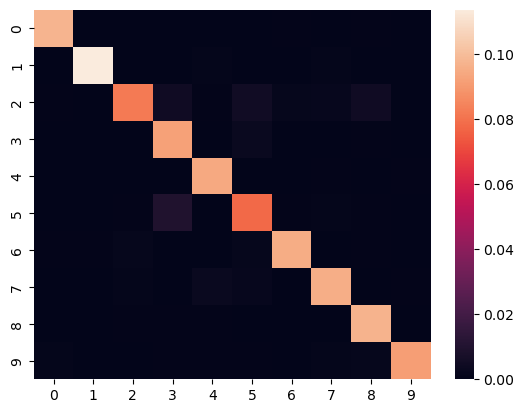

In [48]:
sns.heatmap(confusion_matrix(y[:yhat.shape[0]],yhat.squeeze().argmax(1))/yhat.shape[0])
# plt.title('Accuracy Score: {:.3e}'.format(accuracy_score(y,yhat)))

In [50]:
torch.save(model.state_dict(),'model_finetune.pt')

Transformer from scratch

In [51]:
class AttentionHead(nn.Module):
    def __init__(self,d_t,d_k):
        super(AttentionHead,self).__init__()
        self.Q = nn.Linear(d_k,d_k)
        self.V = nn.Linear(d_k,d_k)
        self.K = nn.Linear(d_k,d_k)
        self.norm = nn.LayerNorm(d_k)
        self.attention = lambda Q,V,K : torch.bmm(nn.Softmax(dim=-1)(torch.bmm(Q,torch.transpose(K,1,2) )/math.sqrt(d_k)),V)
    def forward(self,input1):

        return self.norm(self.attention(self.Q(input1),self.V(input1),self.K(input1))+input1)
        
class MultiHead(nn.Module):
    def __init__(self,d_t,d_k,n_h):
        super(MultiHead,self).__init__()
        self.heads =  nn.ModuleList(AttentionHead(d_t,d_k) for i in range(n_h))
        self.merger = nn.Linear(n_h,1)
    def forward(self,input1):
        res = torch.empty(*input1.shape,len(self.heads))
        for i,m in enumerate(self.heads):
            res[...,i] =m(input1)
        return self.merger(res).squeeze(-1)
class Transformer(nn.Module):
    def __init__(self,d_t,d_k,n_h,n_layers):
        super(Transformer,self).__init__()
        self.embedder = nn.LazyLinear(d_k)
        self.pos_embedding = torch.tensor([ [math.sin(i/1000**((j-1))/d_k) ] if i%2==1 else [math.cos(i/1000**((j-1))/d_k)] for i in range(d_t) for j in range(d_k)  ])
        self.attention_layers = nn.ModuleList( MultiHead(d_t+1,d_k,n_h) for i in range(n_layers))
        self.class_token = nn.parameter.Parameter(torch.normal(torch.zeros(d_k),1/d_k))
        self.norm = nn.LayerNorm(d_k)
    def forward(self,input1):
        
        
        input1_ = torch.cat( (self.class_token.broadcast_to([input1.shape[0],1,self.class_token.shape[0]]), self.embedder(input1)),axis=1)
        + self.pos_embedding[None,:,:]
        input1__ = self.norm(input1_)
        temp = []
        for i,m in enumerate(self.attention_layers):
            if i!=0: temp.append(m(temp[-1]))
            else: temp.append(m(input1__))
        
        return temp[-1][:,-1,:]
    
    
class ViT(nn.Module):
    def __init__(self,d_t,d_k,n_h,n_layers):
        super(ViT,self).__init__()
        self.transformer = Transformer(d_t,d_k,n_h,n_layers)
        self.classifier = nn.Sequential( nn.Linear(d_k,16), nn.ReLU(),nn.Linear(16,10))
    def forward(self,input1):

        return self.classifier(self.transformer(input1))

In [52]:
def loss_fn(model,batch):
    loss = torch.nn.CrossEntropyLoss(reduction = 'none')

    return loss(model(batch[0]),batch[1])



In [66]:
transform= torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((28,28)),torchvision.transforms.Normalize(0,1),\
                            torchvision.transforms.Lambda(lambda x:x.reshape(16,49).flatten(start_dim=1))]  )

dataset = torchvision.datasets.MNIST(root='/home/e_/OneDrive/SoC/tasks/',download=True,transform=transform)
tr_ds,val_ds = torch.utils.data.random_split(dataset,[.8,.2])
tr_dl = DataLoader(tr_ds,64,shuffle=True)
val_dl = DataLoader(val_ds,64,shuffle=True)

model = ViT(d_t=16,d_k=32,n_h=12,n_layers=4)



optim = torch.optim.Adam(model.parameters(),lr=1e-4)

train_history_scratch=train(model, loss_fn, tr_dl, val_dl, optim, 30)   

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

In [67]:
# X = dataset.data[val_ds.indices]
yhat = []
y= []
model.eval()
for sample in tqdm(val_dl):
    with torch.no_grad():yhat.append(model(sample[0]))
    y.append(sample[1])
yhat = torch.cat(yhat,0)
y = torch.cat(y,0)

  0%|          | 0/188 [00:00<?, ?it/s]

<AxesSubplot:>

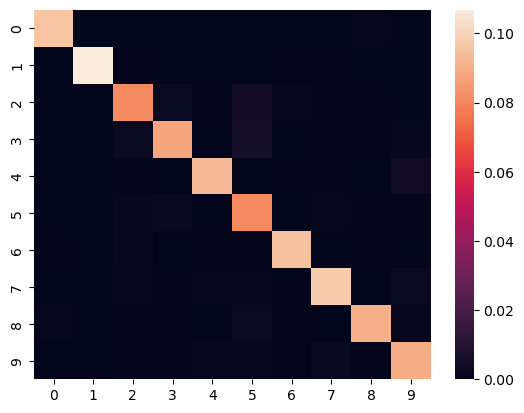

In [78]:
sns.heatmap(confusion_matrix(y.detach().numpy(),yhat.detach().numpy().argmax(1))/yhat.shape[0])
# plt.title('Accuracy Score: {:.3e}'.format(accuracy_score(y,yhat>.5)))

In [69]:
torch.save(model.state_dict(),'transformer_scratch.pt')

In order to implement a Quantum vision transformer (QviT), several things are needed. First would be a method to embed our data. Let's assume our samples $x\in X$ can be linearized as $n$ vectors of shape $d$. Then we can use amplitutde encoding to encode our data to a superposition of qubits. In practice it would be better to pass our input through a classical neural network to decrease the size of the input before embedding it. 
After this we should implement a method to perform attention layer. Instead of using two matrices (Query and Key) we can use a single matrix $$W\equiv QK^T$$
Thus our attention head can be expressed as
$$A_{i,j}(W,V,x)=\text{Activation Function}\left( \frac{x_iWx_j^T}{d}\right). $$
Before implementing a parametrized circuit for the $xWx^T$, it is beneficial to consider which properties it should have. We know that it needs to connect each qubit to each other to perform matrix multiplication. We know that we would be limited to unitary matrices given quantum nature of our system. We also know that we need  $\frac{N^2-N}{2}$ parameters if we want to be able to use all possible matrices (this comes from all operators being unitary and restricting the system to use real matrices only).  

Pyramid circuit introduced in "Classical and Quantum Algorithms for Orthogonal Neural
Networks" can be used for this task. Similarly, dataloaders mentioned in the "Quantum Vision Transformers" can be used to load the data. After performing $x_iWx_j^T$ calculation using quantum circuits, we can perform the activation function clasically then calculate $Vx_i$ using a similar circuit. In the sketch below, I assumed x and A are 3x3 matrices.

In [70]:
dev = qml.device('default.qubit', wires=['n_'+str(i) for i in range(3)]+['d_'+str(i) for i in range(3)], shots=1000)
@qml.qnode(dev)
def Circuit_t8_A():
    

    # Load |X_1>

 
    # Load <X_2|
    for i in reversed(range(2)):qml.Beamsplitter(.5, 0, ['d_'+str(i),'d_'+str(i+1)])
    qml.Hadamard('d_0')
      

    
    # Load |X_2>
    qml.Hadamard('d_0')
    for i in range(2):qml.Beamsplitter(.5, 0, ['d_'+str(i),'d_'+str(i+1)])
    qml.CNOT(['n_1','d_0'])
    
    # Load |X_3>
    qml.Hadamard('d_0')
    for i in range(2):qml.Beamsplitter(.5, 0, ['d_'+str(i),'d_'+str(i+1)])
    qml.CNOT(['n_2','d_0'])
    ######################
    for i in range(2):qml.Beamsplitter(.5, 0, ['n_'+str(i),'n_'+str(i+1)])
    for i in reversed(range(2)):qml.Beamsplitter(.5, 0, ['d_'+str(i),'d_'+str(i+1)])
    
    
    return qml.expval(qml.PauliZ(['ancilla']))


In [71]:
# dev = qml.device('default.qubit', wires=5, shots=1000)
# @qml.qnode(dev)
def Load_X():
    li = []
    # Load ||X||
    li.append(qml.PauliX('d_0'))
    for i in range(2):li.append(qml.Beamsplitter(.5, 0, ['d_'+str(i),'d_'+str(i+1)]))
    return li

def Load_xi(wire,C_not=False,is_reversed=False):
    li = []
    if is_reversed:
        
        for i in reversed(range(2)):li.append(qml.Beamsplitter(.5, 0, ['n_'+str(i),'n_'+str(i+1)]))
        li.append(qml.PauliX('n_0'))
    else:
        li.append(qml.PauliX('n_0'))
        for i in range(2):li.append(qml.Beamsplitter(.5, 0, ['n_'+str(i),'n_'+str(i+1)]))
        if C_not:li.append(qml.CNOT(['d_'+str(wire),'n_0']))
    return li 

def Load_W(length):
    li = []
    for i in range(2*length-2):
        j = length-abs(length-1-i)
        if i%2: 
            for _ in range(j):
                if _%2==0: li.append(qml.Beamsplitter(.5, 0, ['n_'+str(_),'n_'+str(_+1)]))
        else:
            for _ in range(j): 
                if _%2: li.append(qml.Beamsplitter(.5, 0, ['n_'+str(_),'n_'+str(_+1)]))
    return li

Text(0.5, 1.0, 'Multiply by W')

<Figure size 640x480 with 0 Axes>

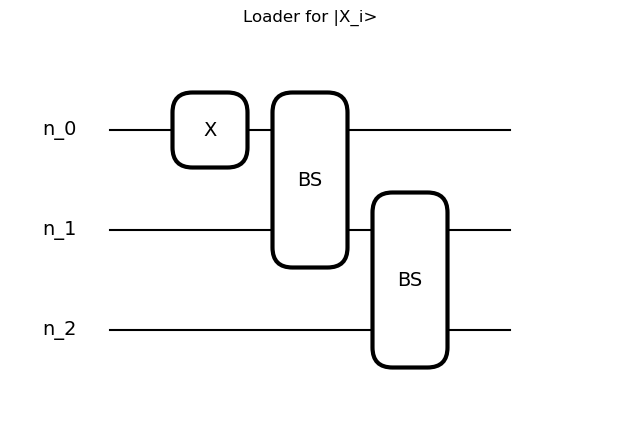

<Figure size 640x480 with 0 Axes>

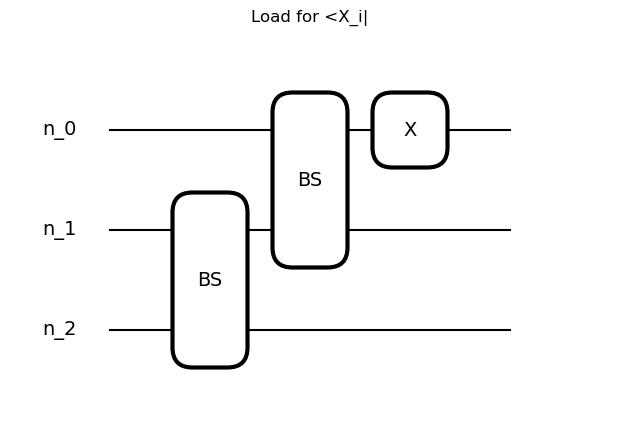

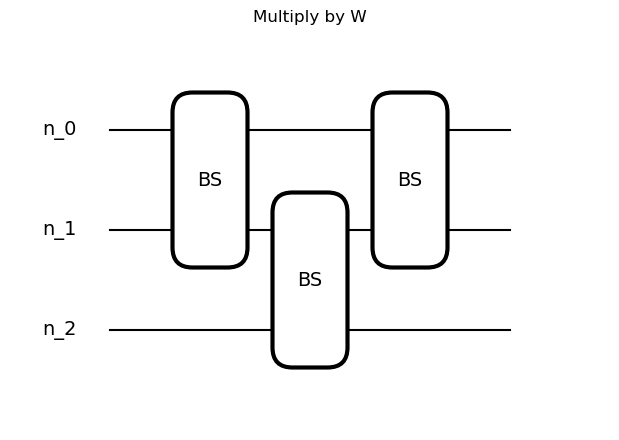

In [72]:
plt.figure()
qml.draw_mpl(Load_xi,show_all_wires=True,wire_order=['n_'+str(i) for i in range(3)])(1,False,is_reversed=False)
plt.title('Loader for |X_i>')

plt.figure()
qml.draw_mpl(Load_xi,show_all_wires=True,wire_order=['n_'+str(i) for i in range(3)])(1,False,is_reversed=True)
plt.title('Load for <X_i|')

qml.draw_mpl(Load_W,show_all_wires=True,wire_order=['n_'+str(i) for i in range(3)])(3)
plt.title('Multiply by W')

In [73]:
def circuit_A():
    return Load_xi(0)+Load_W(3)+Load_xi(0,is_reversed=True)+[qml.expval(qml.PauliZ(['n_0']))]
def circuit_V():
    return Load_xi(0)+Load_W(3)+[qml.expval(qml.PauliZ(['n_'+str(i)])) for i in range(3)]

Text(0.5, 1.0, 'Quantum Circuit to Calculate $A_{ij}=x_iWx_j^T$')

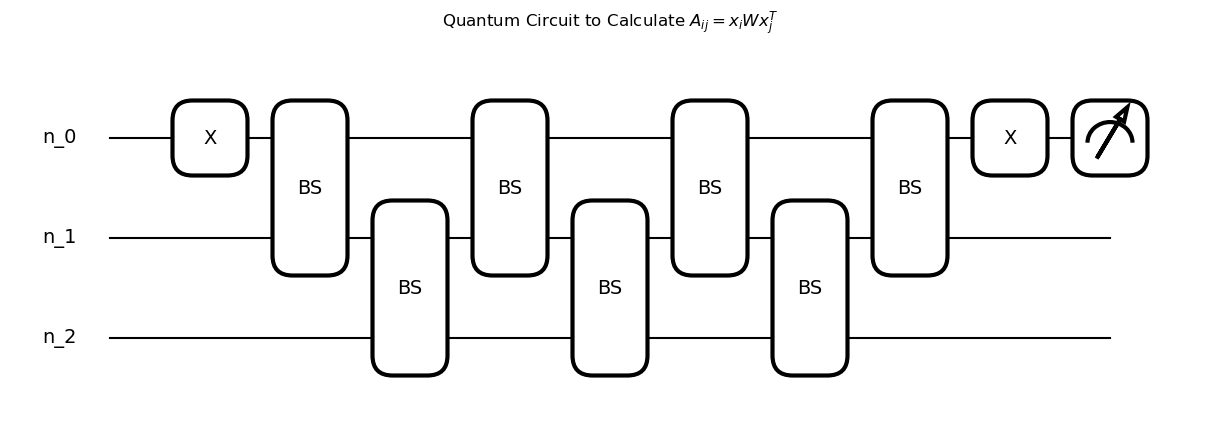

In [74]:
# plt.figure(figsize=(5,5))
qml.draw_mpl(circuit_A)()
plt.title(r'Quantum Circuit to Calculate $A_{ij}=x_iWx_j^T$')


Text(0.5, 1.0, 'Quantum Circuit to Calculate $Vx_i$')

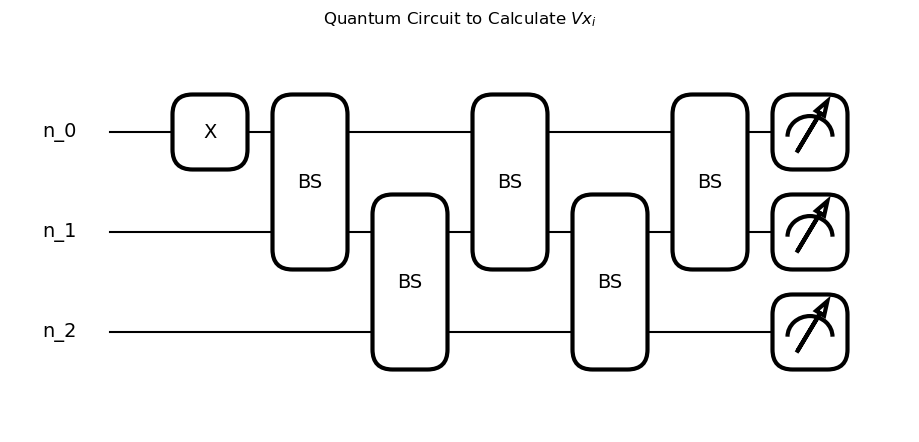

In [75]:
# plt.figure(figsize=(5,5))
qml.draw_mpl(circuit_V)()
plt.title(r'Quantum Circuit to Calculate $Vx_i$')
